In [1]:
%%time
import sys, os
year = '2023'
path_gen = '/home/eliasmfs/Erasmus MC/Projects/Cerebellar_Open_Closed_Loops'
path_data = f'/mnt/User_Data/UserData/eliasmfs/Cerebellar_Open_Closed_Loops/SlowData/'
path_code = f'{path_gen}'
path_functions = f'{path_code}/Functions'
sys.path.append(path_data)
sys.path.append(path_functions)

from Run import *
from tqdm import tqdm
from scipy.signal import butter, lfilter, sosfiltfilt, find_peaks
import matplotlib.style as style 
style.use('seaborn-colorblind')


record = {}
record['Noise'] = True
record['PC'] = True
record['DCN'] = True
record['IO'] = True 
record['conn_N_PC'] = True
record['Input_presyn'] = True

save = 1
show = 0

noise_gain_range =  [1]

exp_run = 120000*ms
N_Cells_PC = 200
N_Cells_DCN = 40
N_Cells_IO = 40
N_Cells_PF = 5
plasticity_range = ['no_Plasticity','Plasticity','after_Plasticity']
coupling_range = ['','_Coupled']
zebrin_range = ['positive', 'negative']

                
seed_number_range = ['closed_open_loops_diff_tau']#closed_open_loops']                  

seed_number = seed_number_range[0]

zebrin = zebrin_range[0]
noise_gain = 1

range_plasticity = ['Plasticity']
range_after_plasticity = ['after_Plasticity']

plas_range = 1
if plas_range > 1:
    for plas_num in range(2,plas_range+1):
        plasticity_range.append(f'Plasticity{plas_num}')
        range_plasticity.append(f'Plasticity{plas_num}')
        plasticity_range.append(f'after_Plasticity{plas_num}')
        range_after_plasticity.append(f'after_Plasticity{plas_num}')
        
f0_range = [0]

parameters_value = { "range_plasticity": range_plasticity, "range_after_plasticity": range_after_plasticity,
                    "PC_I_intrinsic": 0.15, "thresh_M": 60*Hz, "delta_weight_BCM": 0, "delta_weight_CS": -0.1,#-0.02

                    "unfiltered": True, "filtered": True, "f0_range": f0_range, "filter_order": 6, 
                    "positive":{
                        "Uncoupled":{'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.2, 'b_OU': -0.7, 
                                     'sigma_OU': 0.7},
                        'Coupled': {'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                    'sigma_OU': 0.7}},
                    'negative':{
                        'Uncoupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                      'sigma_OU': 0.3},
                        'Coupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.6, 
                                    'sigma_OU': 0.7}}}


Params, Noise_frozen, Values, Synaps, net_name = frozen_tun(seed_number_range,N_Cells_PC,N_Cells_DCN,N_Cells_IO,path_data,exp_run)
IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources

dt = Params['Seed_'+str(seed_number)].dt
dt_rec = float(Params['Seed_'+str(seed_number)].dt_rec)
time_x = [x * dt for x in range(0,int(exp_run/dt))]
time_x_rec = [x * dt for x in range(0,int(exp_run/dt_rec))]


coupling = '_Coupled'
plasticity = 'no_Plasticity'
f0 = 0

zebrin_col = dict(positive='b',negative='r')
linstyle = dict(no_Plasticity='-',after_Plasticity='--')

WARNING    <timed exec>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
 [py.warnings]



CPU times: user 30.7 s, sys: 9.32 s, total: 40 s
Wall time: 47.5 s


## Figure 1 B

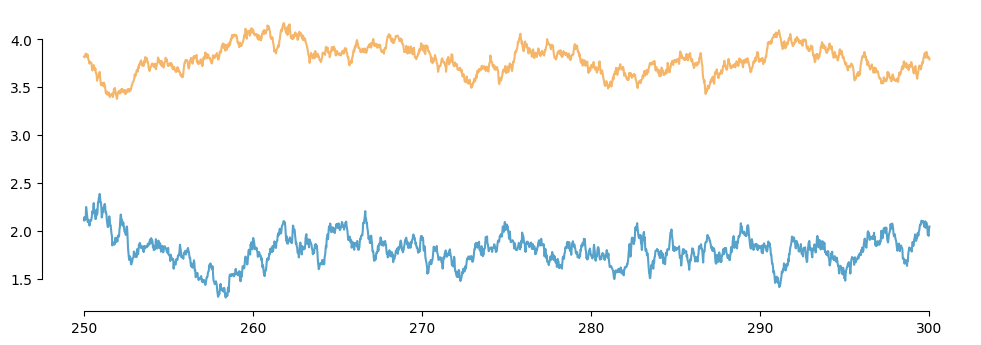

In [2]:
color_arr = ['#0e7ab5b2','#f2972ab2']

start = int(10000)
end = int(12000)
x_ax = linspace(int(start/40),int(end/40),int(end-start))
Noise_I = output_load_run('Noise',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['I']

fig = plt.figure(figsize=(12, 4),dpi=100)
ii = 0
for N_Noise in [1,5]:#range(N_Cells_PF):
    y_ax = Noise_I+N_Noise/2*10e-10
    plot(x_ax,y_ax[N_Noise][start:end]/nA*amp,color_arr[ii],label=f'PF {N_Noise}')
    ii+=1
sns.despine(trim=True)
# yticks([])
# legend(loc='upper right')
plt.show()

## Figure 1 C

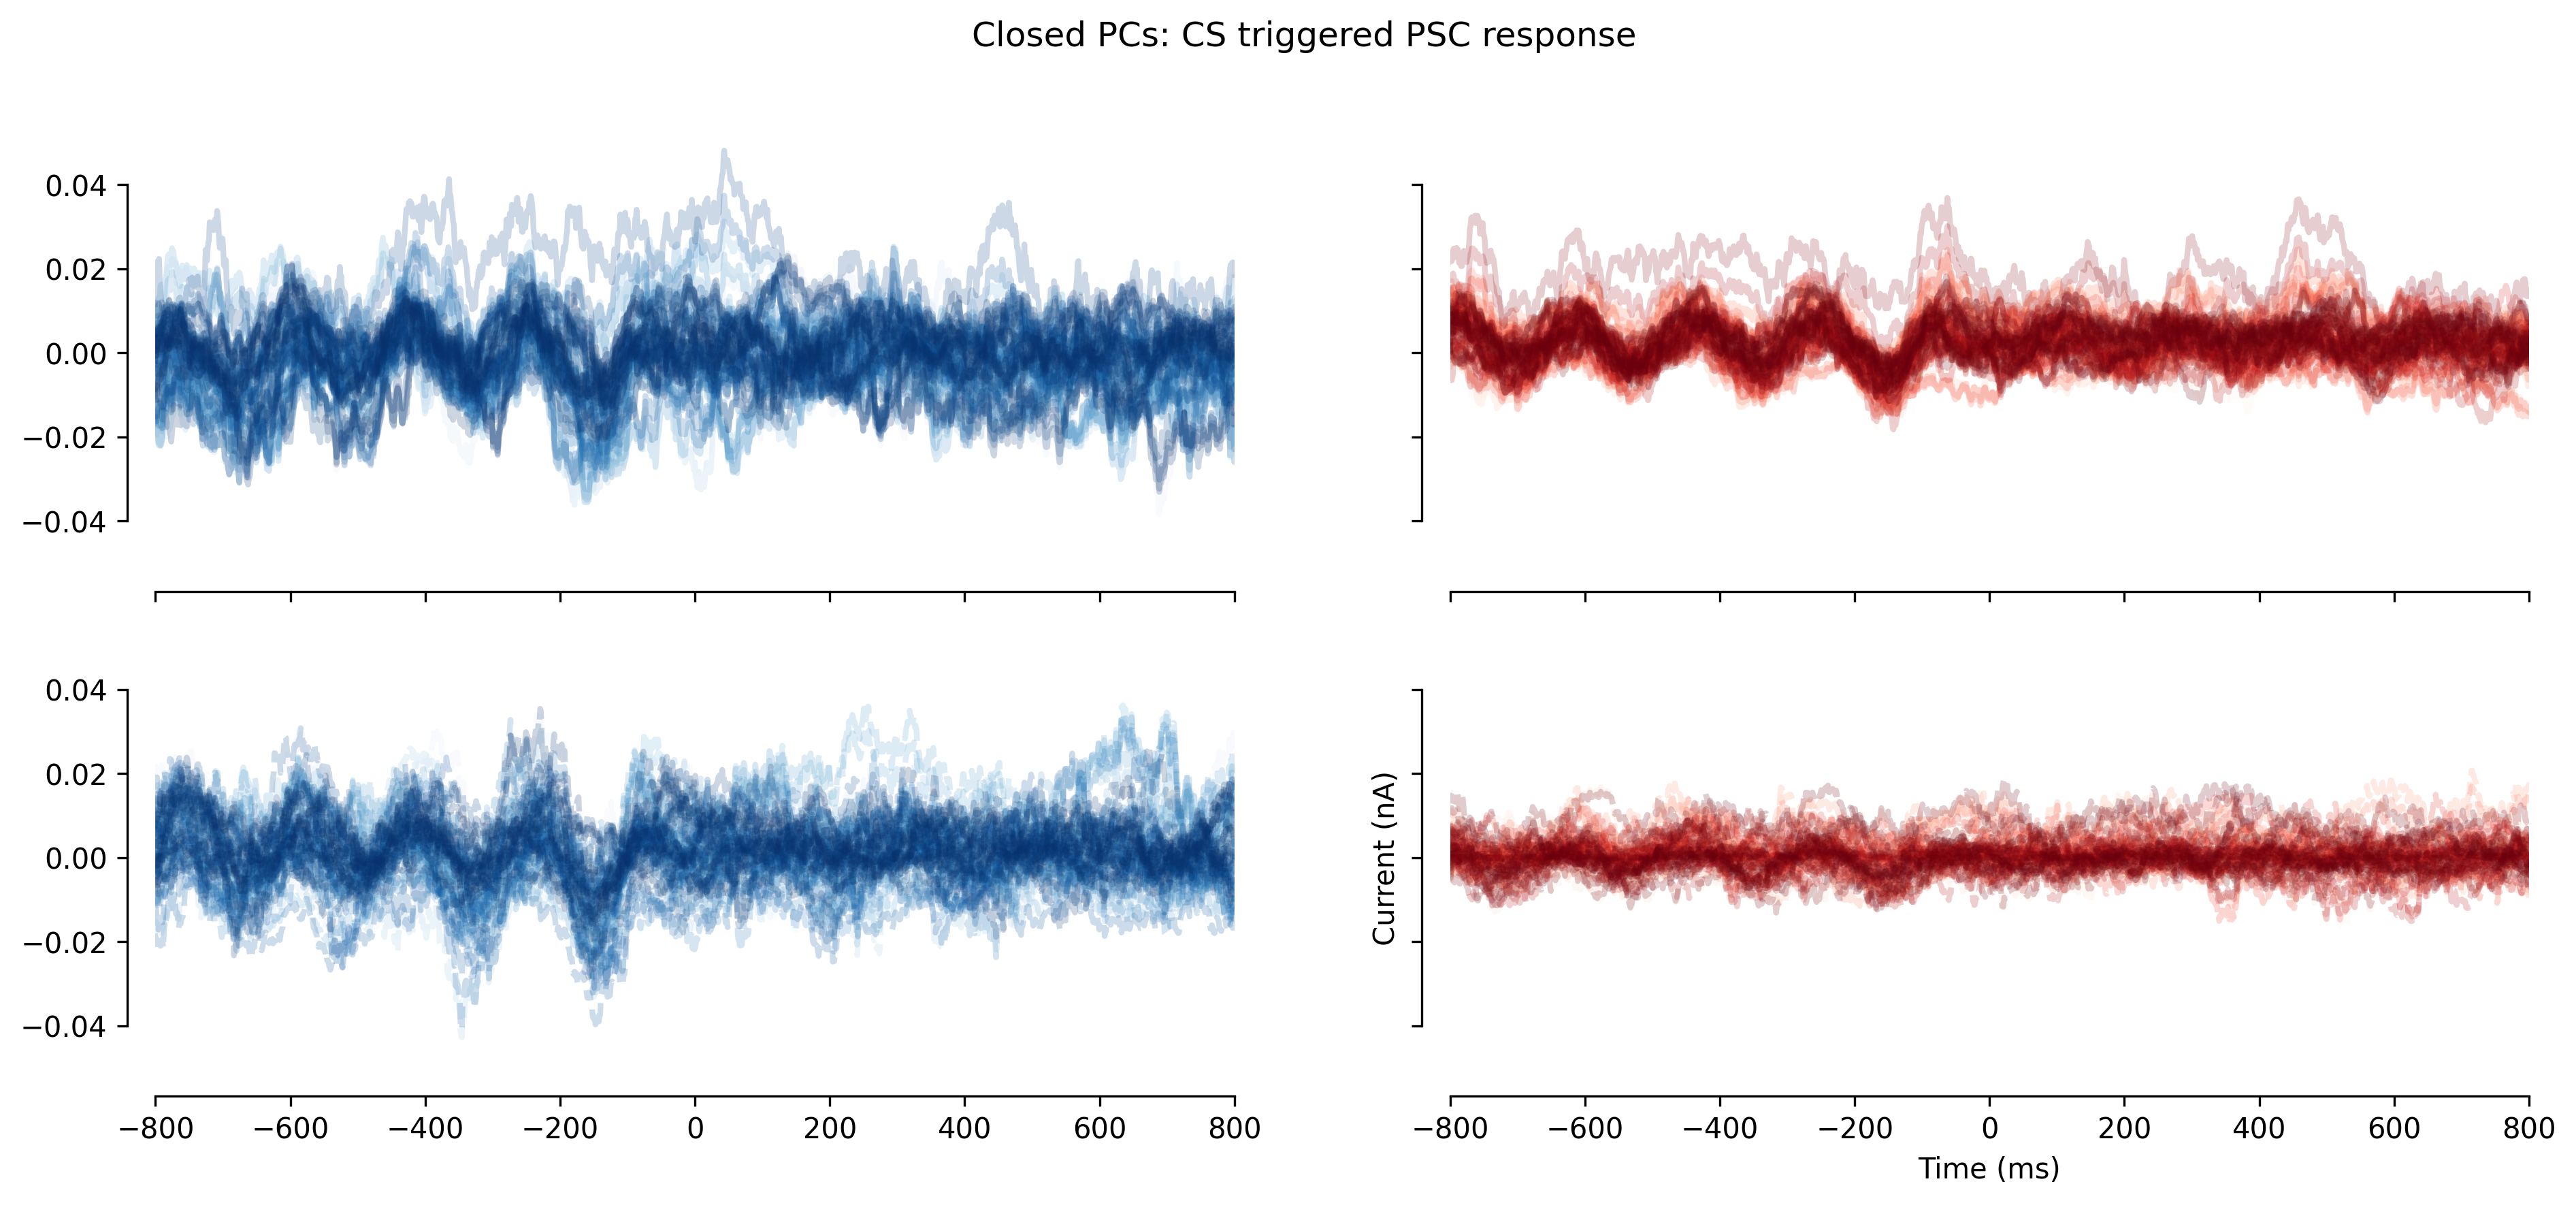

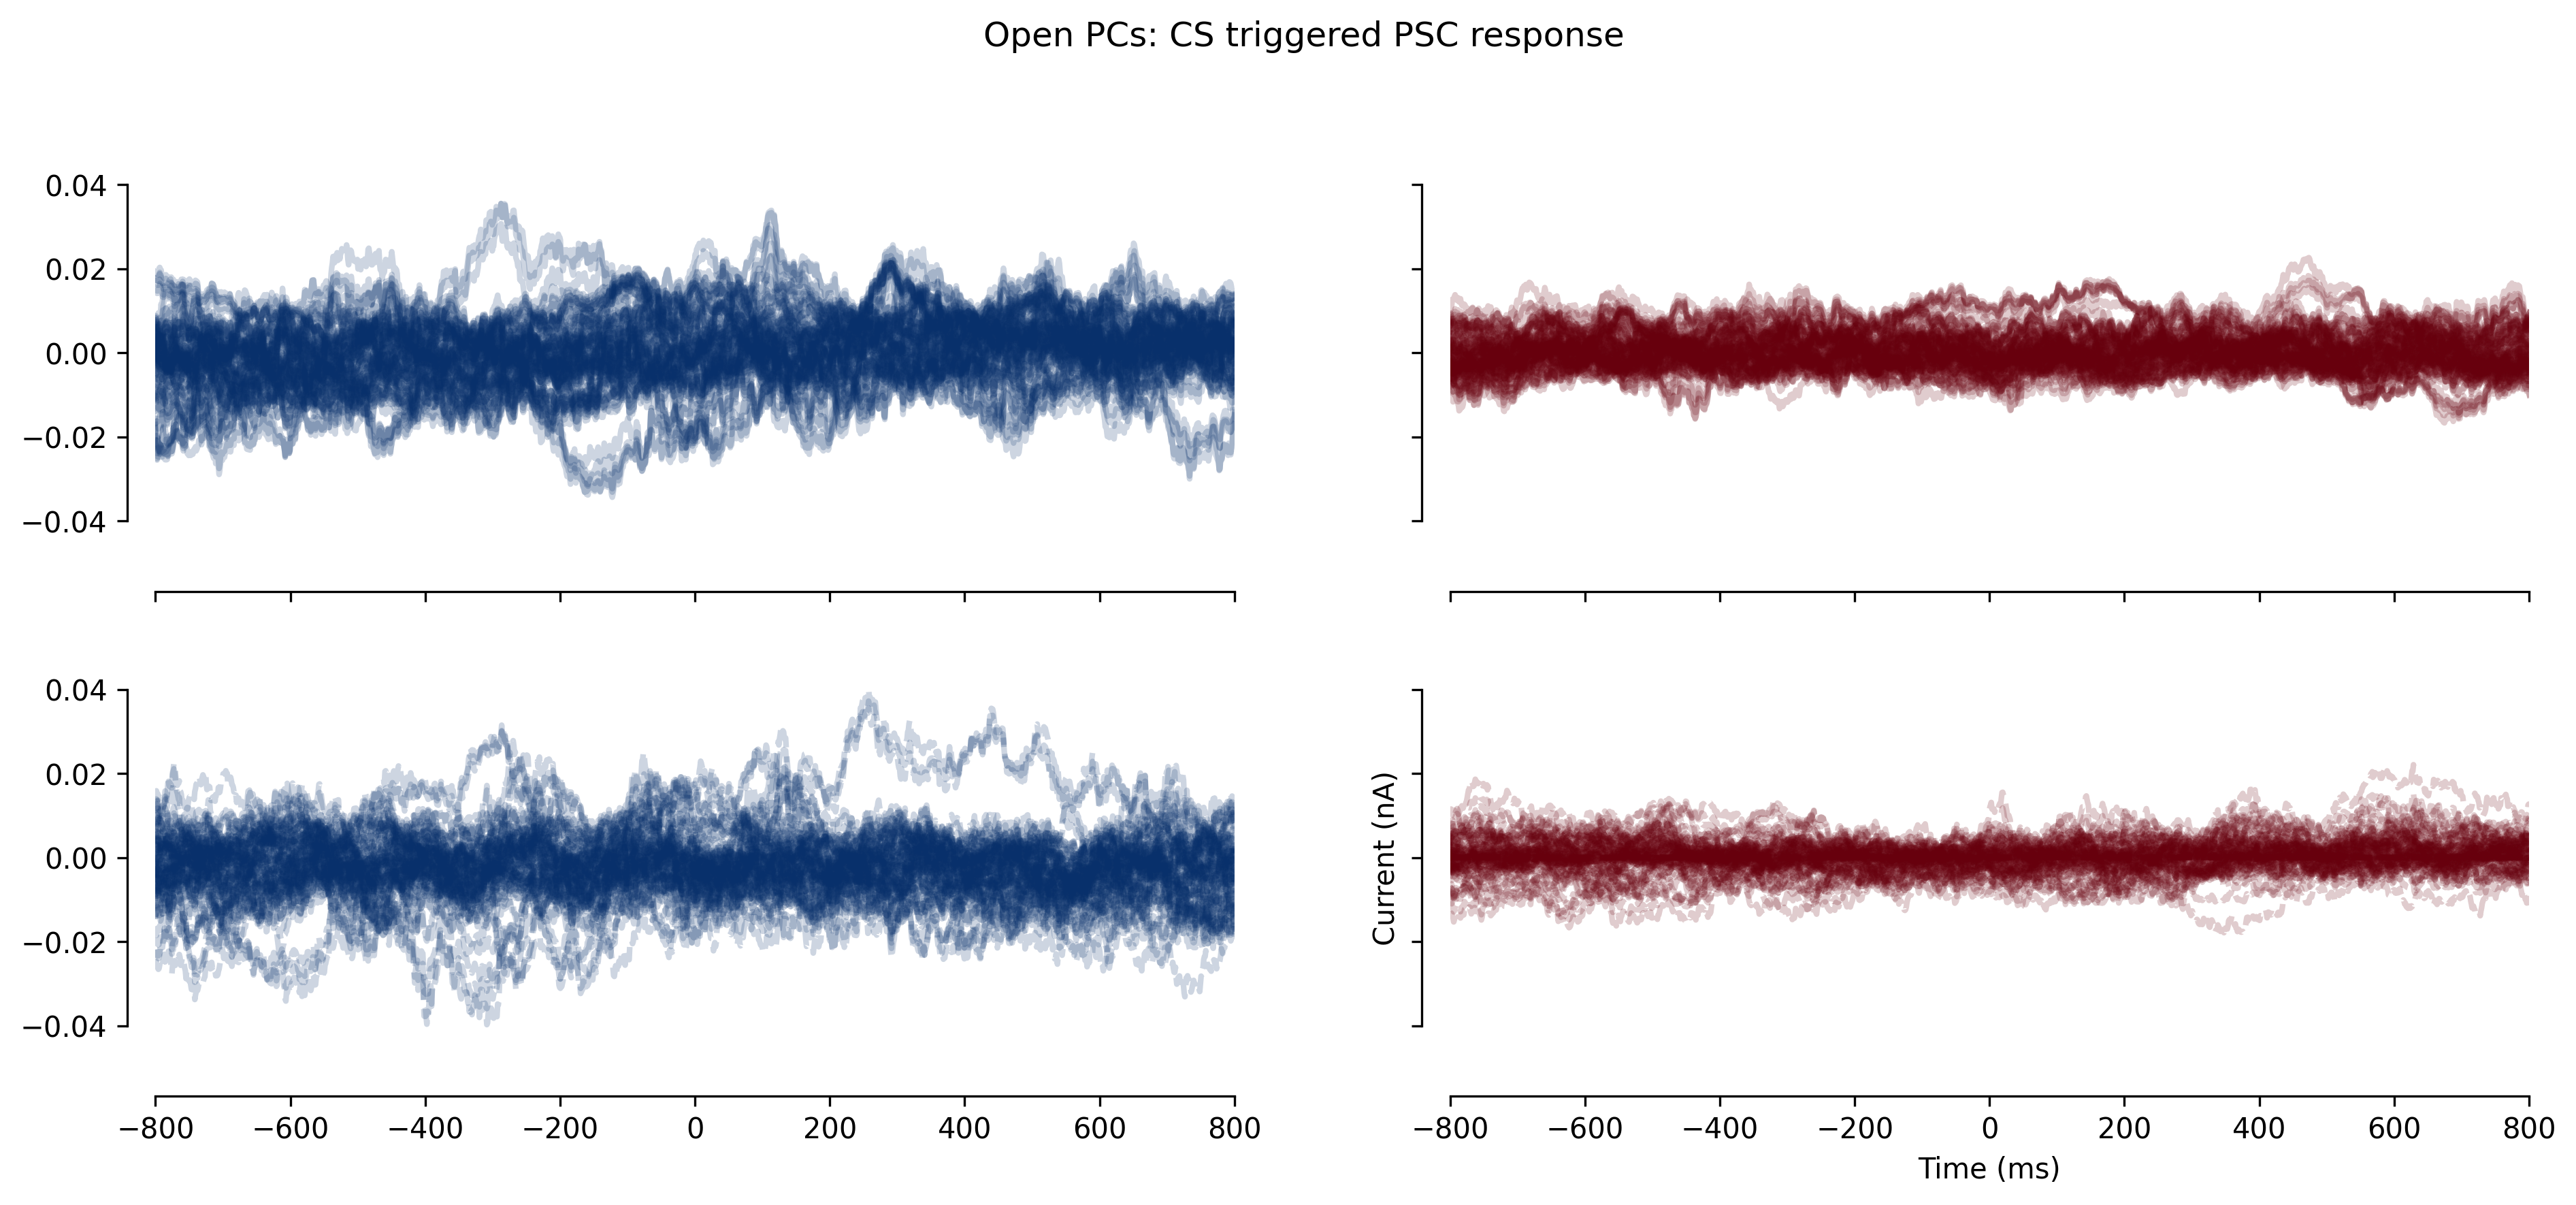

CPU times: user 15.7 s, sys: 2.35 s, total: 18.1 s
Wall time: 48.2 s


In [3]:
%%time
step = 2.5
data=[]
for f0 in f0_range[0:1]:
    for zebrin in ['negative','positive']:
        for plasticity in ['no_Plasticity','after_Plasticity']:
            for coupling in ['_Coupled']:
                IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources
                PC_output = output_load_run('PC',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                IO_output = output_load_run('IO',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                IO_spikes = output_load_run('IO_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                PF_trig_big = []
                IO_trig_big = []
                for pc_num in range(N_Cells_PC):
                    spike_times = IO_spikes[f'{IO_num_con[pc_num]}']
                    PF_trig = []
                    IO_trig = []
                    for spike_time in spike_times:
                        start = int(spike_time*second/dt_rec)-int(step*second/dt_rec)
                        end = int(spike_time*second/dt_rec)+int(step*second/dt_rec)
                        if spike_time < step: continue
                        if spike_time+step > exp_run/second: continue
                        PF_trig.append(PC_output['I_Noise'][pc_num][start:end]/nA)
                        IO_trig.append(IO_output['Vs'][IO_num_con[pc_num]][start:end]/mV)
                    if not PF_trig: continue
                    if not IO_trig: continue 
                    PF_trig_avg = mean(PF_trig,axis=0)
                    IO_trig_avg = mean(IO_trig,axis=0)
                    row=dict(cell=pc_num,f0=f0,zebrin=zebrin,plasticity=plasticity,coupling=coupling,PF_trig_avg=PF_trig_avg,IO_trig_avg=IO_trig_avg)
                    data.append(row)
df_all_IO_trig_PF = pd.DataFrame(data)    


fig,axs=plt.subplots(ncols=2,nrows=2,figsize=(15,6),dpi=300,sharex=True,sharey=True)
suptitle(f'Closed PCs: CS triggered PSC response')
for col,zebrin in enumerate(zebrin_range):
    if zebrin == 'positive': 
        cmap = plt.get_cmap('Blues')
    elif zebrin == 'negative':
        cmap = plt.get_cmap('Reds')
    for row,plasticity in enumerate(['no_Plasticity','after_Plasticity']):
        for pc_num in range(100):
            PF_trig_avg = df_all_IO_trig_PF[(df_all_IO_trig_PF['cell']==pc_num)&(df_all_IO_trig_PF['zebrin']==zebrin)&(df_all_IO_trig_PF['plasticity']==plasticity)&(df_all_IO_trig_PF['f0']==f0)&(df_all_IO_trig_PF['coupling']==coupling)]
            if PF_trig_avg.empty:
                continue
            PF_trig_avg = PF_trig_avg.iloc[0]['PF_trig_avg']
            axs[row,col].plot(linspace(-step*1000,step*1000,len(PF_trig_avg)),PF_trig_avg-PF_trig_avg[0], linestyle=linstyle[plasticity],lw=2,color=cmap(3*(2+pc_num)),alpha=0.2,label=plasticity)
xlim(-800,800)
ylim(-0.05,0.05)
sns.despine(trim=True,offset=10)
ylabel('Current (nA)')
xlabel('Time (ms)')
# plt.savefig(f'tau_CS_PSC_close_pc.svg')
plt.show()


fig,axs=plt.subplots(ncols=2,nrows=2,figsize=(15,6),dpi=300,sharex=True,sharey=True)
suptitle(f'Open PCs: CS triggered PSC response')
for col,zebrin in enumerate(zebrin_range):
    if zebrin == 'positive':
        cmap = plt.get_cmap('Blues')
    elif zebrin == 'negative':
        cmap = plt.get_cmap('Reds')
    for row,plasticity in enumerate(['no_Plasticity','after_Plasticity']):
        for pc_num in range(100,200):
            PF_trig_avg = df_all_IO_trig_PF[(df_all_IO_trig_PF['cell']==pc_num)&(df_all_IO_trig_PF['zebrin']==zebrin)&(df_all_IO_trig_PF['plasticity']==plasticity)&(df_all_IO_trig_PF['f0']==f0)&(df_all_IO_trig_PF['coupling']==coupling)]
            if PF_trig_avg.empty:
                continue
            PF_trig_avg = PF_trig_avg.iloc[0]['PF_trig_avg']
            axs[row,col].plot(linspace(-step*1000,step*1000,len(PF_trig_avg)),PF_trig_avg-PF_trig_avg[0], linestyle=linstyle[plasticity],lw=2,color=cmap(3*(2+pc_num)),alpha=0.2,label=plasticity)
xlim(-800,800)
ylim(-0.05,0.05)
sns.despine(trim=True,offset=10)
ylabel('Current (nA)')
xlabel('Time (ms)')
# plt.savefig(f'tau_CS_PSC_open_pc.svg')
plt.show()

## Figure 1 D

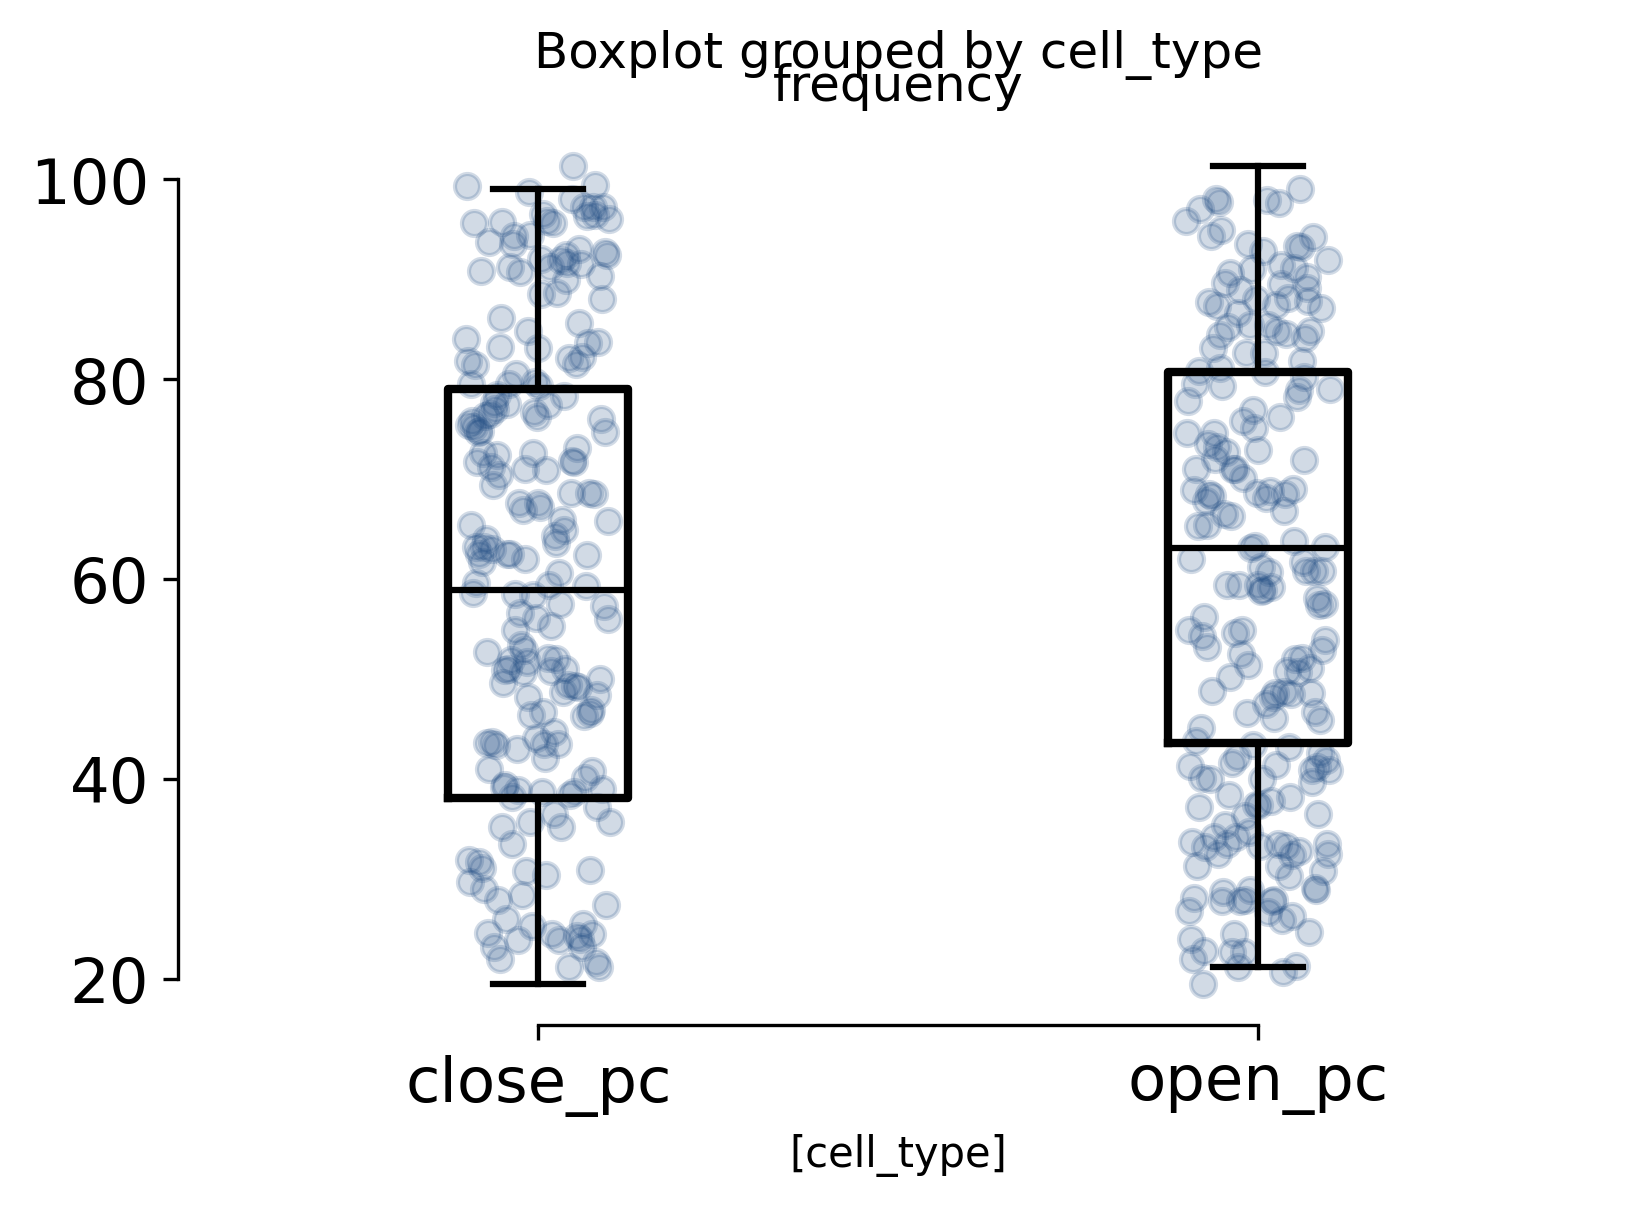

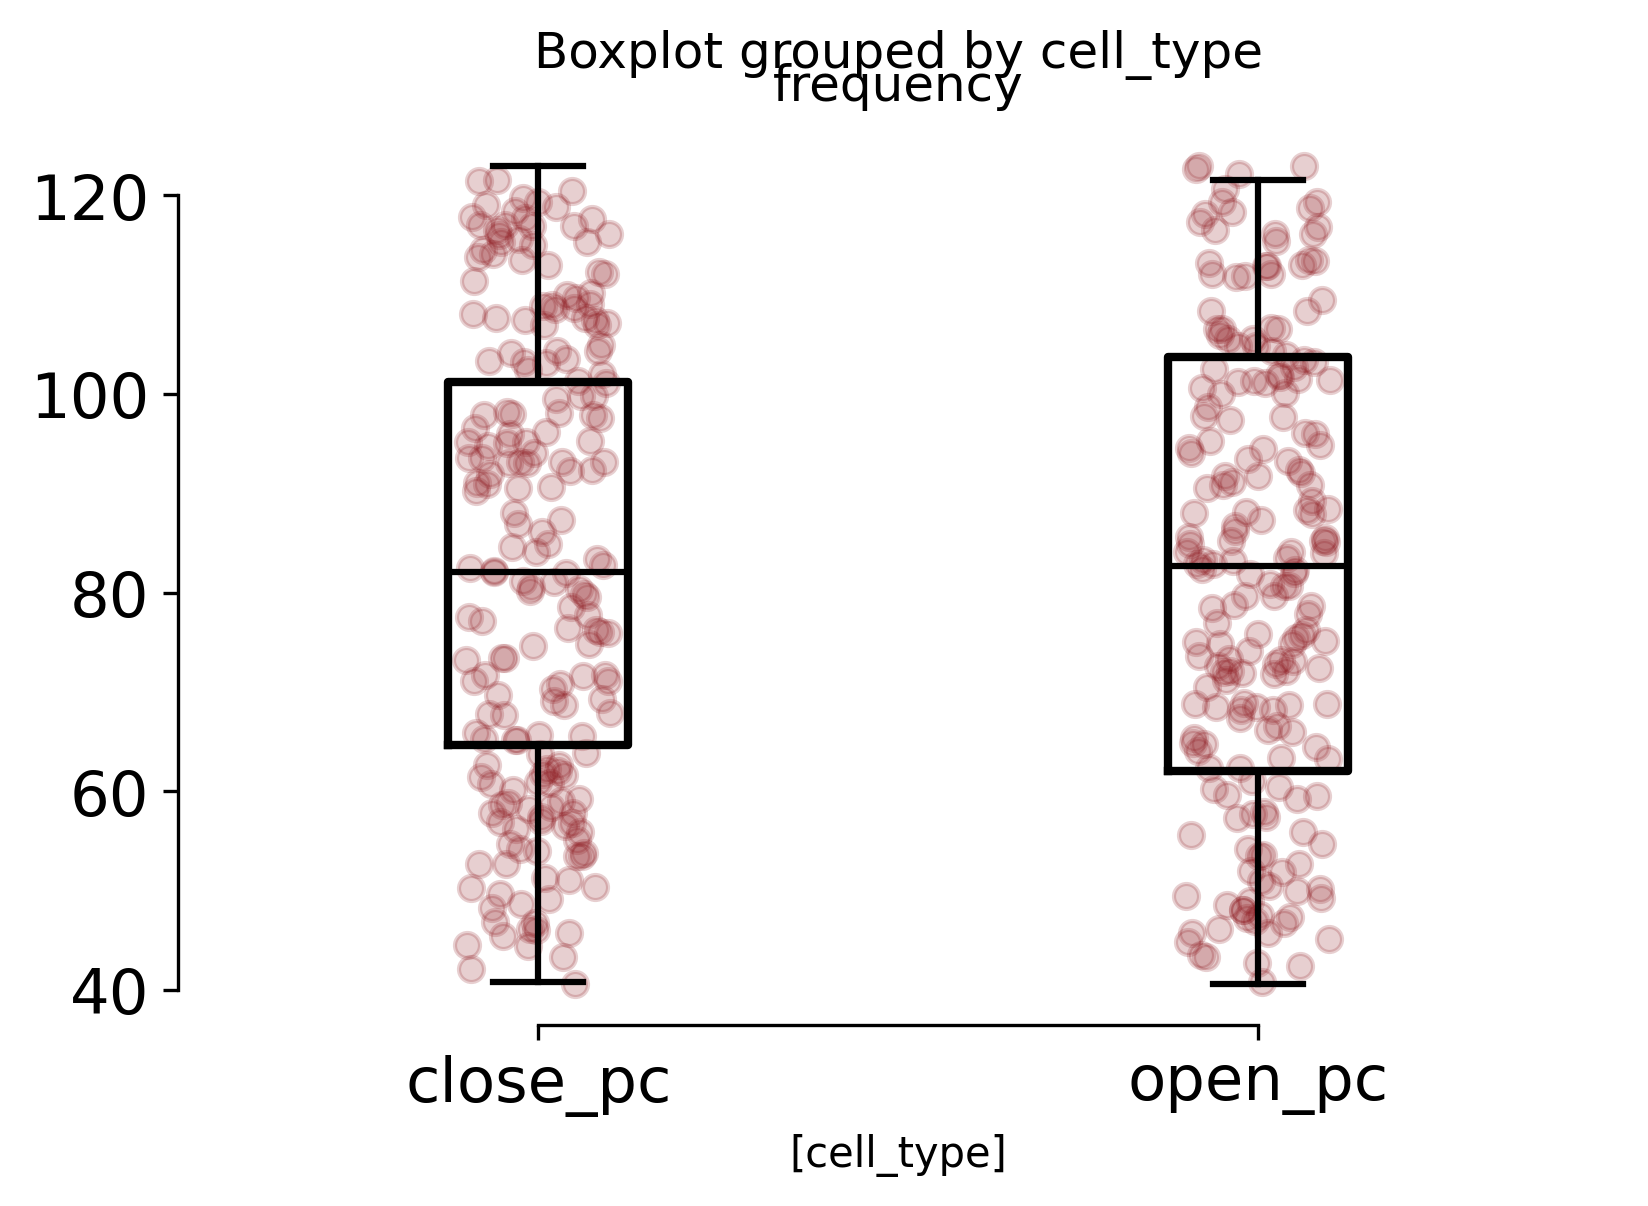

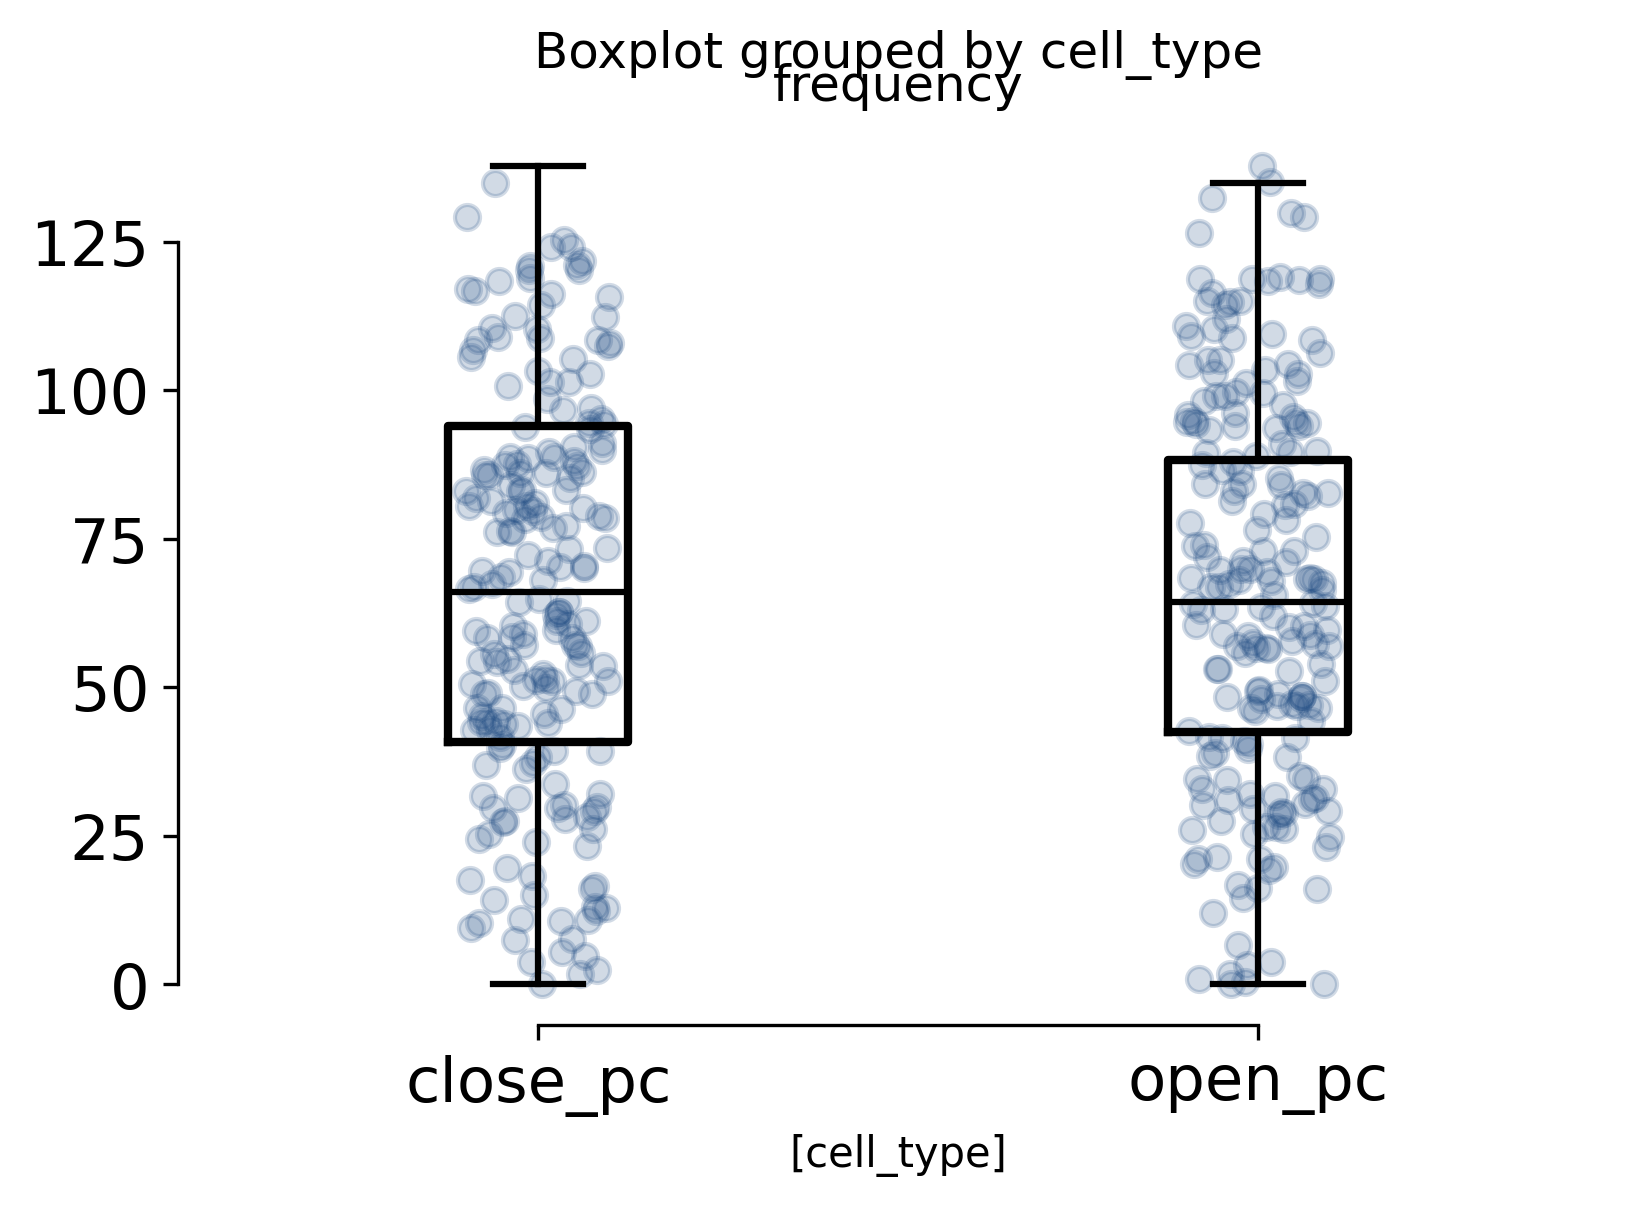

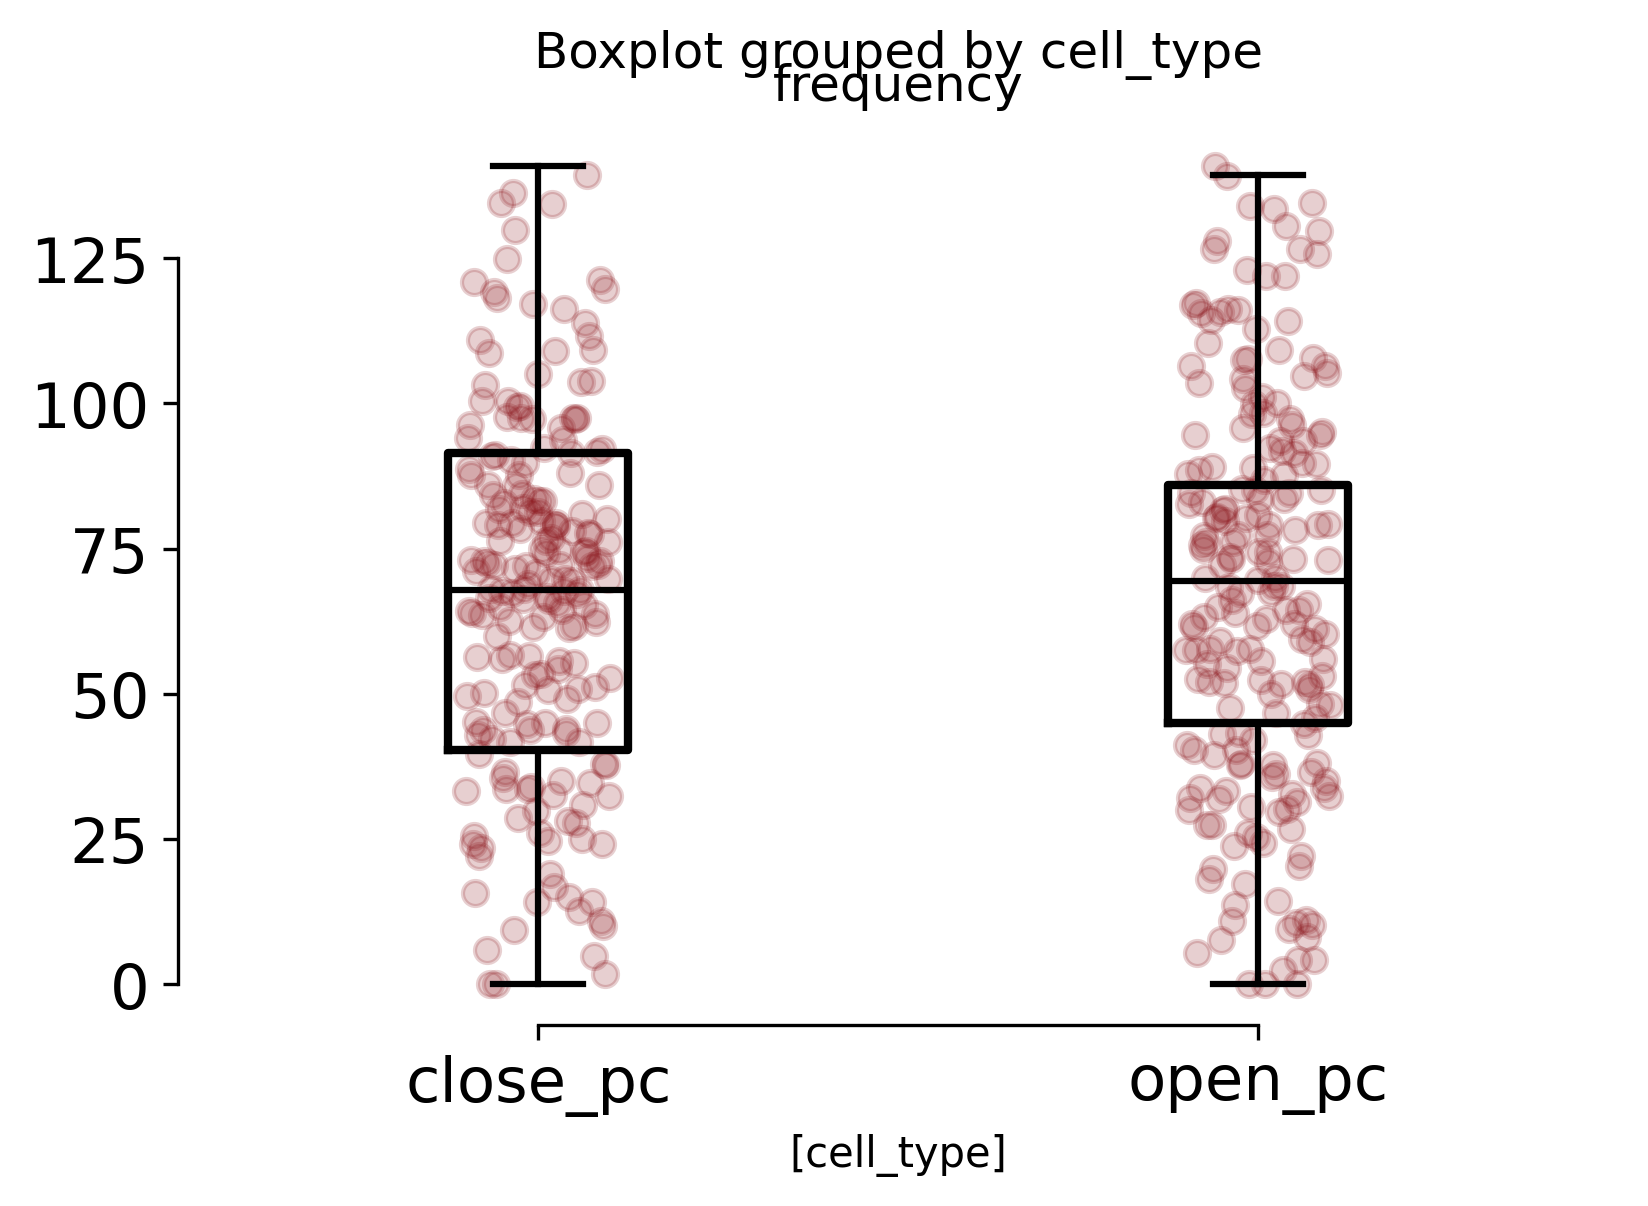

CPU times: user 1.07 s, sys: 589 ms, total: 1.66 s
Wall time: 8.28 s


In [4]:
%%time
t_start = 1 * second
t_stop = 119 * second
bin_size = 1 * second
coupling = '_Coupled'

names = {}
for plasticity in plasticity_range:
    if plasticity == 'no_Plasticity': names[f'{plasticity}'] = 'NP'
    elif plasticity == 'Plasticity': names[f'{plasticity}'] = 'P1'
    elif plasticity == 'Plasticity2': names[f'{plasticity}'] = 'P2'
    elif plasticity == 'Plasticity3': names[f'{plasticity}'] = 'P3'
    elif plasticity == 'Plasticity4': names[f'{plasticity}'] = 'P4'
    elif plasticity == 'after_Plasticity': names[f'{plasticity}'] = 'AP1'
    elif plasticity == 'after_Plasticity2': names[f'{plasticity}'] = 'AP2'
    elif plasticity == 'after_Plasticity3': names[f'{plasticity}'] = 'AP3'
    elif plasticity == 'after_Plasticity4': names[f'{plasticity}'] = 'AP4'

cell_pop_sizes = dict(PC=N_Cells_PC,IO=N_Cells_IO,DCN=N_Cells_DCN)
colors = dict(positive='#1c4981',negative='#8a1218')        
cell_pop_sizes = dict(all_pc = range(200),close_pc = range(100),open_pc = range(100,200))
        
data = []
cell_name = 'PC'
for coupling in (['', '_Coupled']):
    for cell_type in ['close_pc','open_pc']:
        for zebrin in zebrin_range:
            for order,plasticity in enumerate(['after_Plasticity','no_Plasticity']):
                spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                for cell_num in cell_pop_sizes[cell_type]:
                    spikes = spikes_output[f'{cell_num}']
                    bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)
                    spike_counts, _ = np.histogram(spikes, bins=bin_edges)
                    mean_count = spike_counts / bin_size
                    row = dict(frequency = mean(mean_count/Hz))
                    row['cell'] = cell_name
                    row['cell_type'] = cell_type
                    row['plasticity'] = names[f'{plasticity}']
                    row['zebrin'] = zebrin
                    row['coupling'] = coupling
                    row['order'] = f'{order}'+names[f'{plasticity}']
                    data.append(row)
df_ff = pd.DataFrame(data)

for plasticity in ['no_Plasticity','after_Plasticity']:
    var = 'frequency'
    x = {}
    y = {}
    for zebrin in zebrin_range:
        x[zebrin] = {}
        y[zebrin] = {}
        for cell_name in ['PC']:
            df_data = df_ff[(df_ff["zebrin"]==zebrin) & (df_ff["cell"]==cell_name) & (df_ff["plasticity"]==names[f'{plasticity}'])]
            Q1, Q3 = percentile(df_data['frequency'],[5,95])
            IQR = Q3 - Q1    #IQR is interquartile range. 
            lower_boundary = Q1 - 1.5 * IQR
            upper_boundary = Q3 + 1.5 * IQR
            df_data2 = df_data[(df_data['frequency'] < upper_boundary) & (df_data['frequency'] > lower_boundary)]
            fig = plt.figure(dpi=300)
            title(f'{cell_name}')

            flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
            bp = df_data2.boxplot(column=var, by=['cell_type'], grid=False, figsize=(4,3), widths=0.25,fontsize=15,
                                 color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                                 boxprops=dict(linestyle='-', linewidth=2),
                                 flierprops=dict(linestyle='-', linewidth=1.5),
                                 medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                                 whiskerprops=dict(linestyle='-', linewidth=1.5),
                                 capprops=dict(linestyle='-', linewidth=1.5),ax = plt.gca(),positions=[2,1])  
            colors = dict(positive='#1c4981',negative='#8a1218')   
            x[zebrin][cell_name] = {}
            y[zebrin][cell_name] = {}
            for i,coupling in enumerate(['close_pc','open_pc']):
                y[zebrin][cell_name][f'{coupling}'] = df_data2.frequency[(df_data2.cell_type==coupling) & (df_data2.plasticity==names[f'{plasticity}'])].dropna()
    #             x[zebrin][cell_name][f'{coupling}'] = [1+i]*len(y[zebrin][cell_name][f'{coupling}'])
                x[zebrin][cell_name][f'{coupling}'] = rand_params(1+i, 1, len(y[zebrin][cell_name][f'{coupling}']), 0.001)#np.random.normal(1+j+(len(plasticity_range[0:1]))*i, 0.12, size=len(y))    # Add some random "jitter" to the x-axis
                scatter(x[zebrin][cell_name][f'{coupling}'], y[zebrin][cell_name][f'{coupling}'], color=f'{colors[zebrin]}', alpha=0.2)
    #         toPlot = zip(x[zebrin][cell_name]['close_pc'], y[zebrin][cell_name]['close_pc'], x[zebrin][cell_name]['open_pc'], y[zebrin][cell_name]['open_pc'])
    #         for tuple in toPlot:
    #             plot([tuple[0], tuple[2]], [tuple[1], tuple[3]], color=f'{colors[zebrin]}',alpha=0.2)
            xticks([1,2],['close_pc','open_pc'])
            sns.despine(trim=True)
            plt.show()

## Figure 1 E

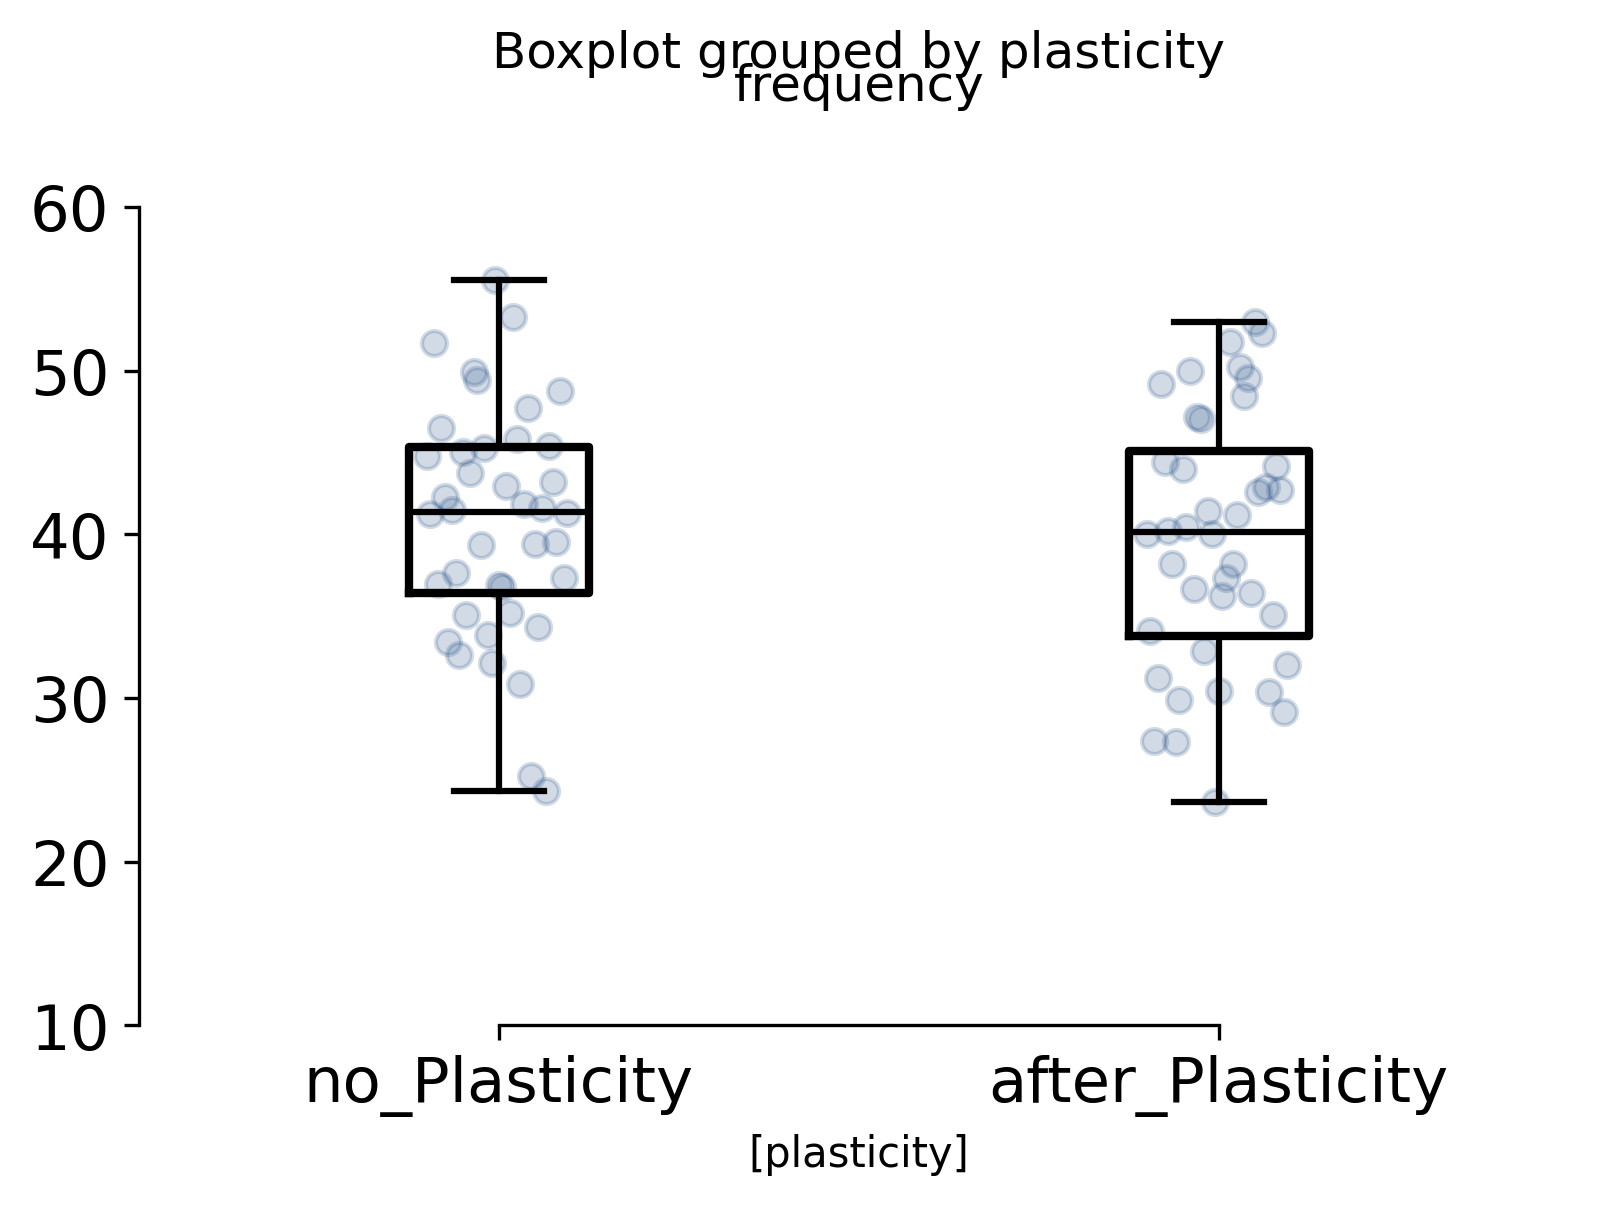

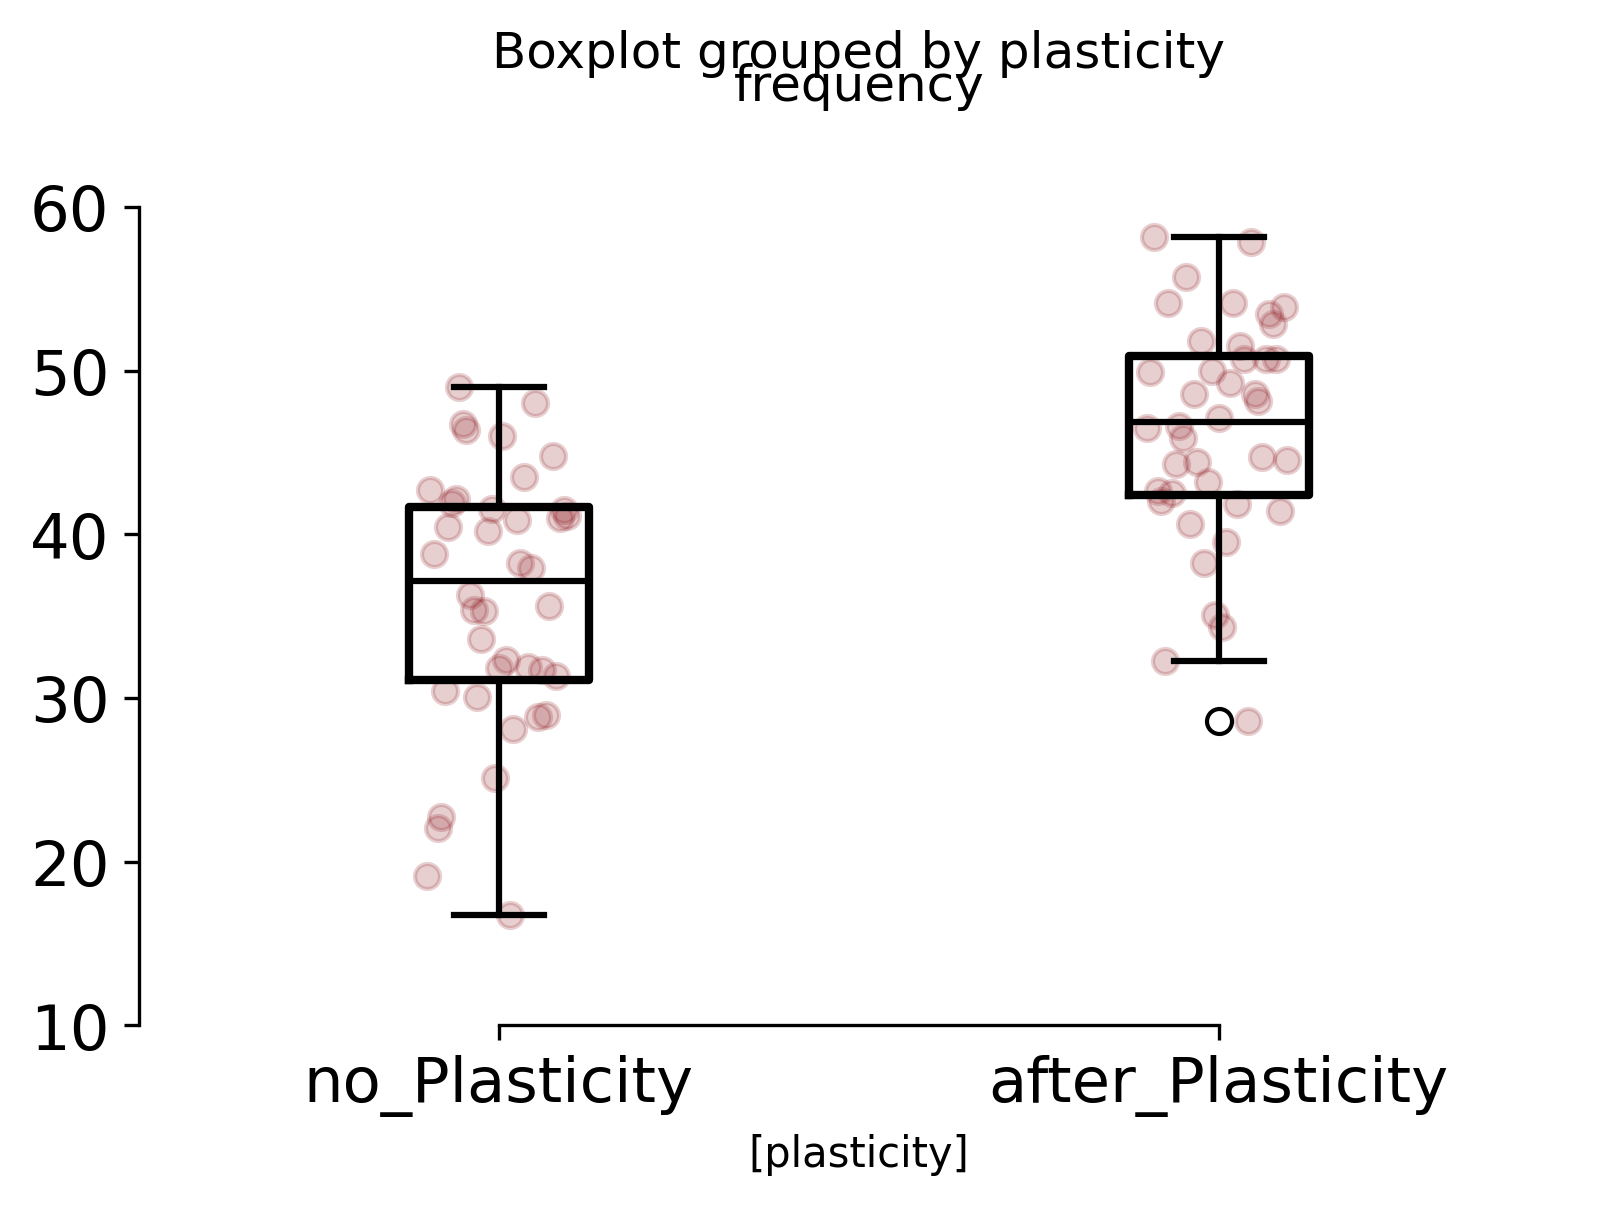

CPU times: user 423 ms, sys: 210 ms, total: 633 ms
Wall time: 2.18 s


In [5]:
%%time
t_start = 1 * second
t_stop = 119 * second
bin_size = 1 * second
coupling = '_Coupled'

cell_pop_sizes = dict(PC=N_Cells_PC,IO=N_Cells_IO,DCN=N_Cells_DCN)
colors = dict(positive='#1c4981',negative='#8a1218')        
        
data = []
for coupling in (['_Coupled']):
    for cell_name in ['DCN']:
        for zebrin in zebrin_range:
            for order,plasticity in enumerate(['after_Plasticity','no_Plasticity']):
                spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                for cell_num in range(cell_pop_sizes[cell_name]):
                    spikes = spikes_output[f'{cell_num}']
                    bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)
                    spike_counts, _ = np.histogram(spikes, bins=bin_edges)
                    mean_count = spike_counts / bin_size
                    row = dict(frequency = mean(mean_count/Hz))
                    row['cell'] = cell_name
                    row['plasticity'] = names[f'{plasticity}']
                    row['zebrin'] = zebrin
                    row['coupling'] = coupling
                    row['order'] = f'{order}'+names[f'{plasticity}']
                    data.append(row)
df_ff = pd.DataFrame(data)

var = 'frequency'
x = {}
y = {}
for zebrin in zebrin_range:
    x[zebrin] = {}
    y[zebrin] = {}
    for cell_name in ['DCN']:
        df_data = df_ff[(df_ff["zebrin"]==zebrin) & (df_ff["cell"]==cell_name)]
        Q1, Q3 = percentile(df_data['frequency'],[5,95])
        IQR = Q3 - Q1    #IQR is interquartile range. 
        lower_boundary = Q1 - 1.5 * IQR
        upper_boundary = Q3 + 1.5 * IQR
        df_data2 = df_data[(df_data['frequency'] < upper_boundary) & (df_data['frequency'] > lower_boundary)]
        fig = plt.figure(dpi=300)
        title(f'{cell_name}')

        flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
        bp = df_data2.boxplot(column=var, by=['plasticity'], grid=False, figsize=(4,3), widths=0.25,fontsize=15,
                             color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                             boxprops=dict(linestyle='-', linewidth=2),
                             flierprops=dict(linestyle='-', linewidth=1.5),
                             medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                             whiskerprops=dict(linestyle='-', linewidth=1.5),
                             capprops=dict(linestyle='-', linewidth=1.5),ax = plt.gca(),positions=[2,1])  
        colors = dict(positive='#1c4981',negative='#8a1218')   
        x[zebrin][cell_name] = {}
        y[zebrin][cell_name] = {}
        for i,plasticity in enumerate(['no_Plasticity','after_Plasticity']):
            y[zebrin][cell_name][f'{plasticity}'] = df_data2.frequency[(df_data2.plasticity==names[f'{plasticity}'])].dropna()
#             x[zebrin][cell_name][f'{coupling}'] = [1+i]*len(y[zebrin][cell_name][f'{coupling}'])
            x[zebrin][cell_name][f'{plasticity}'] = rand_params(1+i, 1, len(y[zebrin][cell_name][f'{plasticity}']), 0.005)#np.random.normal(1+j+(len(plasticity_range[0:1]))*i, 0.12, size=len(y))    # Add some random "jitter" to the x-axis
            scatter(x[zebrin][cell_name][f'{plasticity}'], y[zebrin][cell_name][f'{plasticity}'], color=f'{colors[zebrin]}', alpha=0.2)
#         toPlot = zip(x[zebrin][cell_name]['close_pc'], y[zebrin][cell_name]['close_pc'], x[zebrin][cell_name]['open_pc'], y[zebrin][cell_name]['open_pc'])
#         for tuple in toPlot:
#             plot([tuple[0], tuple[2]], [tuple[1], tuple[3]], color=f'{colors[zebrin]}',alpha=0.2)
        xticks([1,2],['no_Plasticity','after_Plasticity'])
        if cell_name == 'DCN': ylim(10,65)
        if cell_name == 'IO': ylim(0,2.6)
        sns.despine(trim=True)
        plt.show()

## Figure 1 F

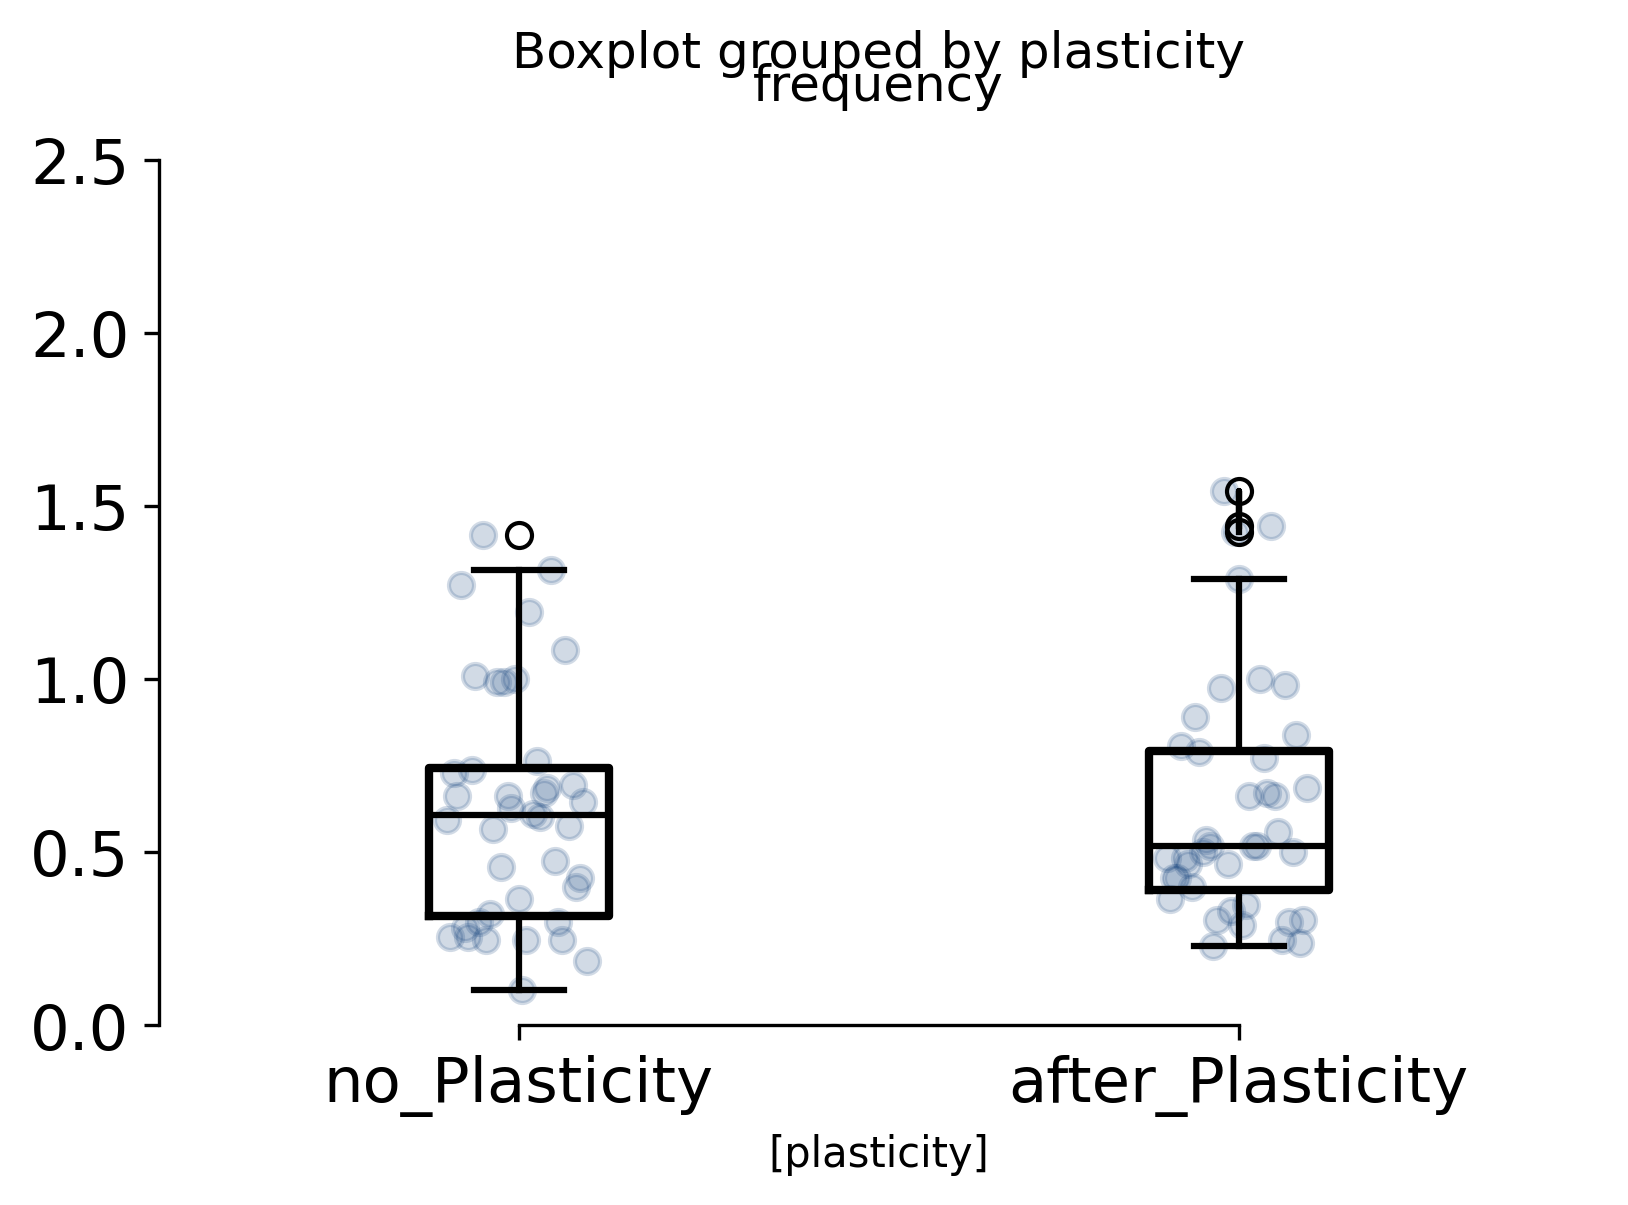

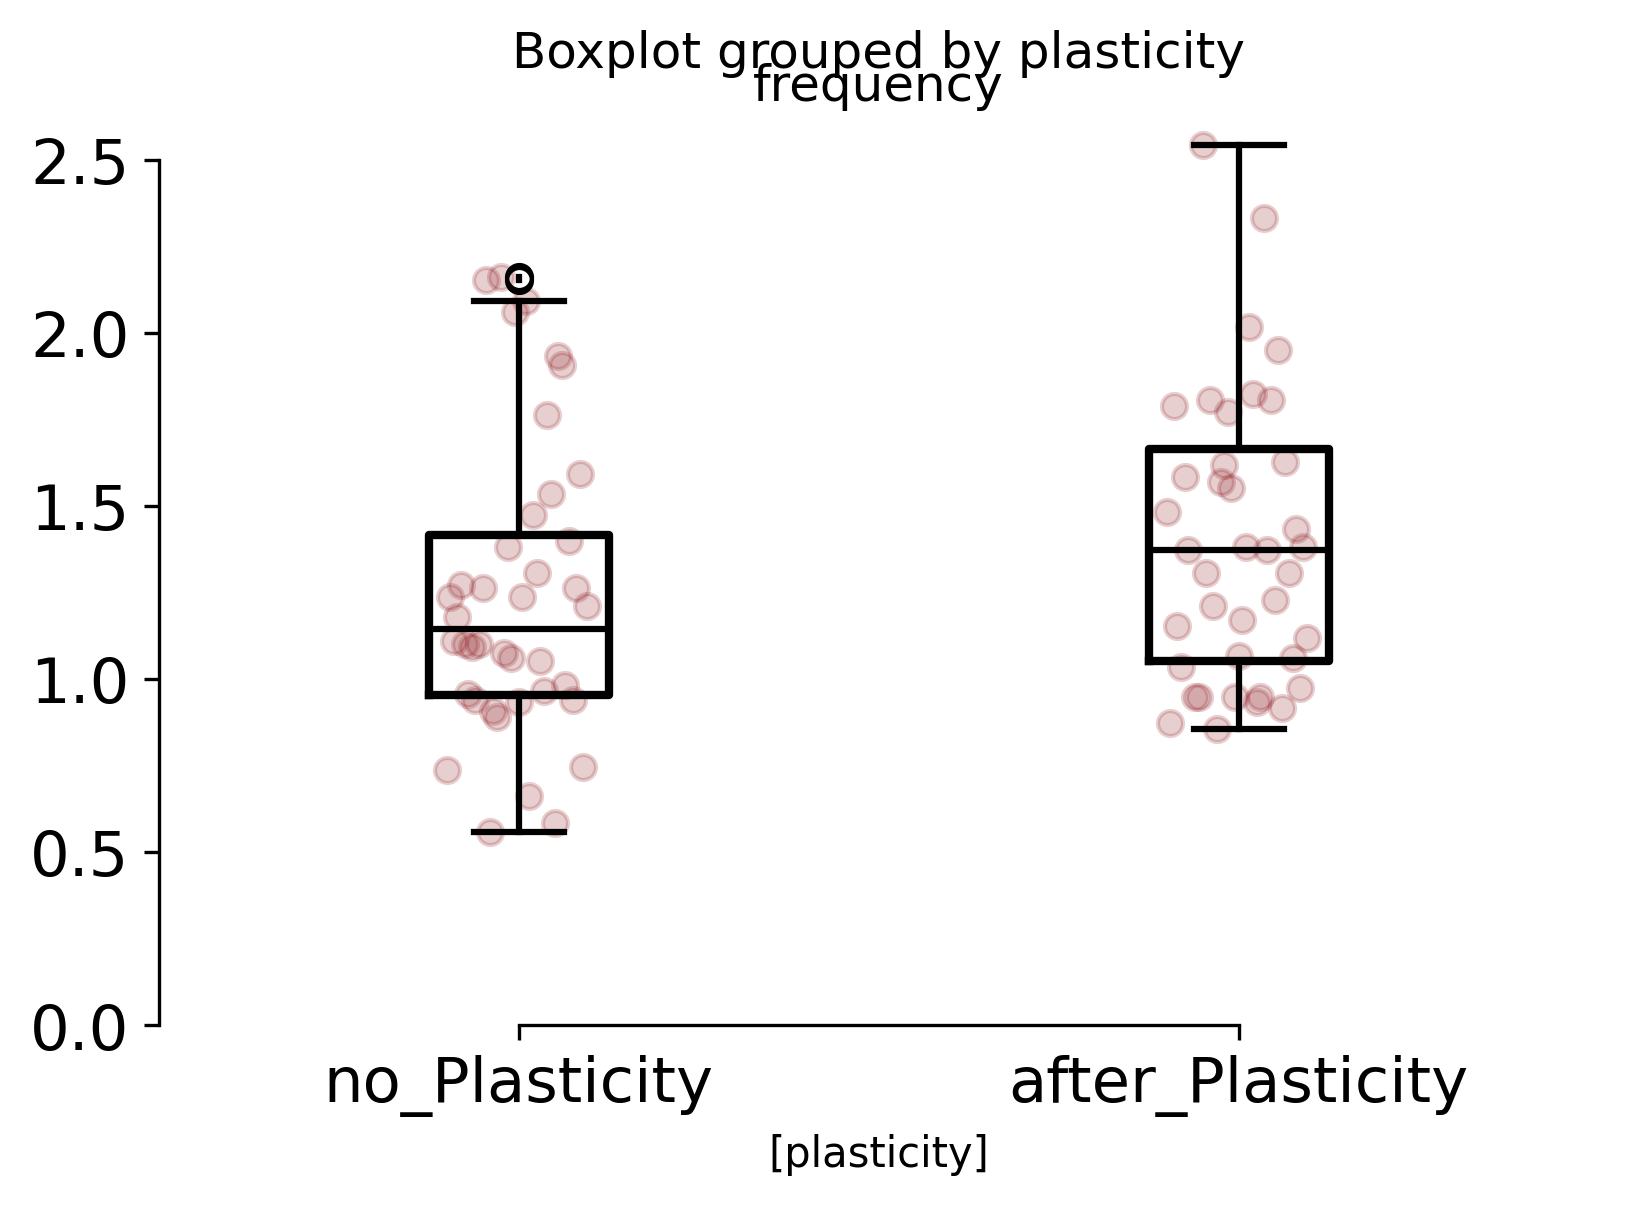

CPU times: user 364 ms, sys: 243 ms, total: 607 ms
Wall time: 1.36 s


In [6]:
%%time
t_start = 1 * second
t_stop = 119 * second
bin_size = 1 * second
coupling = '_Coupled'

cell_pop_sizes = dict(PC=N_Cells_PC,IO=N_Cells_IO,DCN=N_Cells_DCN)
colors = dict(positive='#1c4981',negative='#8a1218')        
        
data = []
for coupling in (['_Coupled']):
    for cell_name in ['IO']:
        for zebrin in zebrin_range:
            for order,plasticity in enumerate(['after_Plasticity','no_Plasticity']):
                spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                for cell_num in range(cell_pop_sizes[cell_name]):
                    spikes = spikes_output[f'{cell_num}']
                    bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)
                    spike_counts, _ = np.histogram(spikes, bins=bin_edges)
                    mean_count = spike_counts / bin_size
                    row = dict(frequency = mean(mean_count/Hz))
                    row['cell'] = cell_name
                    row['plasticity'] = names[f'{plasticity}']
                    row['zebrin'] = zebrin
                    row['coupling'] = coupling
                    row['order'] = f'{order}'+names[f'{plasticity}']
                    data.append(row)
df_ff = pd.DataFrame(data)

var = 'frequency'
x = {}
y = {}
for zebrin in zebrin_range:
    x[zebrin] = {}
    y[zebrin] = {}
    for cell_name in ['IO']:
        df_data = df_ff[(df_ff["zebrin"]==zebrin) & (df_ff["cell"]==cell_name)]
        Q1, Q3 = percentile(df_data['frequency'],[5,95])
        IQR = Q3 - Q1    #IQR is interquartile range. 
        lower_boundary = Q1 - 1.5 * IQR
        upper_boundary = Q3 + 1.5 * IQR
        df_data2 = df_data[(df_data['frequency'] < upper_boundary) & (df_data['frequency'] > lower_boundary)]
        fig = plt.figure(dpi=300)
        title(f'{cell_name}')

        flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
        bp = df_data2.boxplot(column=var, by=['plasticity'], grid=False, figsize=(4,3), widths=0.25,fontsize=15,
                             color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                             boxprops=dict(linestyle='-', linewidth=2),
                             flierprops=dict(linestyle='-', linewidth=1.5),
                             medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                             whiskerprops=dict(linestyle='-', linewidth=1.5),
                             capprops=dict(linestyle='-', linewidth=1.5),ax = plt.gca(),positions=[2,1])  
        colors = dict(positive='#1c4981',negative='#8a1218')   
        x[zebrin][cell_name] = {}
        y[zebrin][cell_name] = {}
        for i,plasticity in enumerate(['no_Plasticity','after_Plasticity']):
            y[zebrin][cell_name][f'{plasticity}'] = df_data2.frequency[(df_data2.plasticity==names[f'{plasticity}'])].dropna()
#             x[zebrin][cell_name][f'{coupling}'] = [1+i]*len(y[zebrin][cell_name][f'{coupling}'])
            x[zebrin][cell_name][f'{plasticity}'] = rand_params(1+i, 1, len(y[zebrin][cell_name][f'{plasticity}']), 0.005)#np.random.normal(1+j+(len(plasticity_range[0:1]))*i, 0.12, size=len(y))    # Add some random "jitter" to the x-axis
            scatter(x[zebrin][cell_name][f'{plasticity}'], y[zebrin][cell_name][f'{plasticity}'], color=f'{colors[zebrin]}', alpha=0.2)
#         toPlot = zip(x[zebrin][cell_name]['close_pc'], y[zebrin][cell_name]['close_pc'], x[zebrin][cell_name]['open_pc'], y[zebrin][cell_name]['open_pc'])
#         for tuple in toPlot:
#             plot([tuple[0], tuple[2]], [tuple[1], tuple[3]], color=f'{colors[zebrin]}',alpha=0.2)
        xticks([1,2],['no_Plasticity','after_Plasticity'])
        if cell_name == 'DCN': ylim(10,65)
        if cell_name == 'IO': ylim(0,2.6)
        sns.despine(trim=True)
        plt.show()